# Simulation of multiple phenotypes given genotypes and covariance
Here we simulate effect size from mixture gaussian distribution and match strong effects with "heavily LD convoluted" SNPs.

## Multivariate simulation

In [108]:
import numpy as np
import os, random

class PhenotypeSimulator:
    def __init__(self, X):
        self.X = X
        self.Y = None
        self.B = None
        self.ld = None
    
    def permute_X(self):
        # break LD structure
        np.random.shuffle(self.X)

    def get_ld(self, save_to = None):
        '''r^2 based LD calculation'''
        self.ld = np.corrcoef(self.X, rowvar = False)
        self.ld = (np.square(self.ld) * np.sign(self.ld)).astype(np.float16)
        if save_to is not None:
            if os.path.isfile(save_to):
                os.remove(save_to)
            np.save(save_to, self.ld)
    
    def load_ld(self, fn):
        self.ld = np.load(fn)
    
    def ld_heatmap(self, out):
        use_abs = np.sum((self.ld < 0).values.ravel()) == 0
        import seaborn as sns
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
        sns.heatmap(self.ld, ax = ax, cmap = cmap, vmin=-1 if not use_abs else 0, 
                    vmax=1, square=True, xticklabels = False, yticklabels = False)
        plt.savefig(out, dpi = 500)
        
    def generate_B(self, pis, U, pi0 = 0):
        '''
        beta ~ \pi_0\delta_0 + \sum \pi_i N_R(0, wU)
        '''
        self.B = np.zeros((self.X.shape[1], U[0].shape[0]))
        nbeta = self.B.shape[0]
        mus = np.zeros(self.B.shape[1])
        for j in range(nbeta):
            if np.random.binomial(1, 1 - pi0, size = 1) > 0:
                sigma = U[np.random.multinomial(1, pis, size = 1).tolist()[0].index(1)]
                self.B[j,:] = np.random.multivariate_normal(mus, sigma, 1)
    
    def generate_Y(self, sigma):
        self.Y = self.X @ self.B + np.random.multivariate_normal(np.zeros(self.B.shape[1]), sigma)
    
    def select_convoluted_snps(self, cutoff1 = 0.8, cutoff2 = 10, cutoff3 = 0.01):
        '''based on LD matrix select SNPs in strong LD with other SNPs 
        yet are independent between themselves'''
        print('Count strong LD')
        import pandas as pd
        ld = pd.DataFrame(self.ld)
        strong_ld_count = ((np.absolute(ld) > cutoff1) * ld).sum(axis = 0).sort_values(ascending = False)
        strong_ld_count = strong_ld_count[strong_ld_count > cutoff2]
        print('Filter by LD')
        exclude = []
        for x in strong_ld_count.index:
            if x in exclude:
                continue
            for y in strong_ld_count.index:
                if y in exclude or y == x:
                    continue
                if np.absolute(ld[x][y]) > cutoff3:
                    exclude.append(y)
        print('Done')
        return [i for i, x in enumerate(strong_ld_count.index) if not x in exclude]
    
    def swap_B(self, strength_index):
        '''Set tops of beta to tops in strength_index'''
        nb = np.zeros(self.B.shape)
        beta_max = np.amax(np.absolute(self.B), axis = 1)
        big_beta_index = [i[0] for i in sorted(enumerate(beta_max), key = lambda x: x[1], reverse = True)]
        random.shuffle(big_beta_index)
        for item in strength_index:
            nb[item,:] = self.B[big_beta_index.pop(0),:]
        for idx in range(nb.shape[0]):
            if not idx in strength_index:
                nb[idx,:] = self.B[big_beta_index.pop(0),:]
        self.B = nb

In [3]:
dat = readRDS('/home/gaow/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds')
attach(dat)

In [5]:
%get X Y --from R
Y = Y.as_matrix()

In [109]:
model = PhenotypeSimulator(X)

In [110]:
model.get_ld('/home/gaow/Documents/GTExV8/FMO2.ld.npy')

In [14]:
from libgaow.regression_data import MASH
mash = MASH(X=X,Y=Y)
mash.set_prior({'identity': np.identity(2), 
                 'single_1': np.array([[1,0],[0,0]]), 
                 'single_2': np.array([[0,0], [0,1]]), 
                 'all_in': np.ones((2,2))}, 
                [0.5,1], 
                [0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02])


In [17]:
mash.pi

array([ 0.9 ,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.02,  0.02])

In [19]:
mash.U.keys()

dict_keys(['null', 'identity.1', 'identity.2', 'single_1.1', 'single_1.2', 'single_2.1', 'single_2.2', 'all_in.1', 'all_in.2'])

In [23]:
pi0 = 0.9
pis = [item / (1 - pi0) for item in mash.pi[1:]]
U = dict([(idx, mash.U[key]) for idx, key in enumerate(mash.U.keys()) if key != 'null'])

{0: array([[ 0.25,  0.  ],
        [ 0.  ,  0.25]]), 1: array([[ 1.,  0.],
        [ 0.,  1.]]), 2: array([[ 0.25,  0.  ],
        [ 0.  ,  0.  ]]), 3: array([[ 1.,  0.],
        [ 0.,  0.]]), 4: array([[ 0.  ,  0.  ],
        [ 0.  ,  0.25]]), 5: array([[ 0.,  0.],
        [ 0.,  1.]]), 6: array([[ 0.25,  0.25],
        [ 0.25,  0.25]]), 7: array([[ 1.,  1.],
        [ 1.,  1.]])}

In [111]:
model.generate_B(pis, U, pi0)

In [112]:
strong_index = model.select_convoluted_snps()

Count strong LD
Filter by LD
Done


In [113]:
model.swap_B(strong_index)

In [114]:
model.generate_Y(np.ones((2,2)))

## M&M analysis

In [116]:
from libgaow.regression_data import MNMASH
import numpy as np
mm = MNMASH(X=model.X,Y=model.Y)
mm.set_prior({'identity': np.identity(2), 
                 'single_1': np.array([[1,0],[0,0]]), 
                 'single_2': np.array([[0,0], [0,1]]), 
                 'all_in': np.ones((2,2))}, 
                [0.5,1], 
                [0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02])

In [117]:
mm.fit(niter=5)

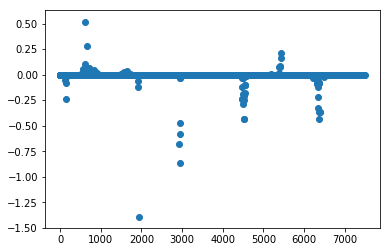

In [120]:
plt.scatter([x+1 for x in range(len(mm.post_mean_mat[:,0]))], mm.post_mean_mat[:,0], cmap="viridis")
ax = plt.gca()
plt.show()

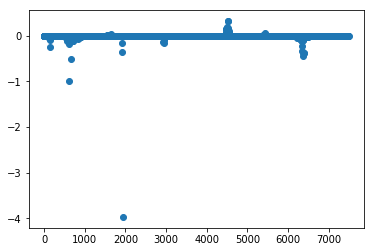

In [121]:
plt.scatter([x+1 for x in range(len(mm.post_mean_mat[:,1]))], mm.post_mean_mat[:,1], cmap="viridis")
ax = plt.gca()
plt.show()